## Phase 1: Screening & Eligibility Analysis (Impaired Driving Study)

In [1]:
# ============================================
# Cell 1 — Imports & simple helpers
# Phase 1: Screening & Eligibility Analysis
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")

DATA_RAW = Path("../data_raw")
ELIG_PATH = DATA_RAW / "Eligibility screening form.xlsx"

def read_xlsx_simple(p: Path) -> pd.DataFrame:
    return pd.read_excel(p, engine="openpyxl")

def to_bool_series(s: pd.Series) -> pd.Series:
    m = s.astype(str).str.strip().str.lower()
    return m.map({
        "yes": True, "y": True, "true": True, "1": True,
        "no": False,  "n": False, "false": False, "0": False
    })

def find_col(df: pd.DataFrame, target: str):
    """Case/space-insensitive column finder."""
    low = {c.lower().strip(): c for c in df.columns}
    return low.get(target.lower().strip())


In [2]:
# ============================================
# Cell 2 — Load & normalize eligibility data
# ============================================

elig_raw = read_xlsx_simple(ELIG_PATH).copy()

# Robust rename for key columns we care about
rename_targets = {
    "qualified and email sent": "qualified_email_sent",
    "did not qualify":          "did_not_qualify",
    "have done the study":      "have_done_study",
    "did not showup":           "did_not_showup",
    "red flags":                "red_flags",
    "needs more checking":      "needs_more_checking",
    "participant's full name":  "full_name",
    "participant's gender":     "gender",
    "what is your age?":        "age",
    "participant's email":      "email",
    "participant's phone number": "phone",
    "what is the most number of drinks you have consumed in one sitting in the past year (refer to the following chart for what constitutes a drink based on alcohol type)?": "max_drinks_one_sitting",
    "do you feel that you are a normal drinker? (by normal we mean do you drink less than or as much as most other people.)": "normal_drinker",
    "do you ever feel guilty about your drinking?": "guilty_about_drinking",
    "are you prone to motion sickness or uncomfortable with virtual reality or other simulated environments?": "motion_sickness",
}

rename_map = {}
for orig, new in rename_targets.items():
    c = find_col(elig_raw, orig)
    if c:
        rename_map[c] = new

elig = elig_raw.rename(columns=rename_map)

# Boolean mirrors for main funnel flags
for col in ["qualified_email_sent", "did_not_qualify", "have_done_study"]:
    if col in elig.columns:
        elig[col + "_raw"] = elig[col]
        elig[col] = to_bool_series(elig[col])

# Optional yes/no flags (we keep original text + boolean)
for col in ["did_not_showup", "red_flags", "needs_more_checking"]:
    if col in elig.columns:
        elig[col + "_raw"] = elig[col]

# Numerics
if "age" in elig.columns:
    elig["age"] = pd.to_numeric(elig["age"], errors="coerce")
if "max_drinks_one_sitting" in elig.columns:
    elig["max_drinks_one_sitting"] = pd.to_numeric(
        elig["max_drinks_one_sitting"], errors="coerce"
    )

# Age bands
elig["age_band"] = pd.cut(
    elig.get("age", pd.Series(dtype=float)),
    bins=[17, 25, 35, 45, 60, 120],
    labels=["18–25", "26–35", "36–45", "46–60", "60+"]
)

# Drinker type (simple heuristic)
if "normal_drinker" in elig.columns or "guilty_about_drinking" in elig.columns:
    norm = to_bool_series(elig.get("normal_drinker", pd.Series(index=elig.index)))
    guilt = to_bool_series(elig.get("guilty_about_drinking", pd.Series(index=elig.index)))
    elig["drinker_type"] = np.select(
        [norm.eq(True), guilt.eq(True)],
        ["Normal", "Possible risk"],
        default="Unknown"
    )

elig_screen = elig.copy()

print("Screening records:", len(elig_screen))
for col in ["qualified_email_sent", "did_not_qualify", "have_done_study"]:
    if col in elig_screen.columns:
        print(f"{col}:", elig_screen[col].value_counts(dropna=False).to_dict())


Screening records: 437
qualified_email_sent: {True: 267, nan: 170}
did_not_qualify: {nan: 270, False: 167}
have_done_study: {nan: 331, True: 106}


Forms submitted: 437
Qualified:       267
Participated:    106


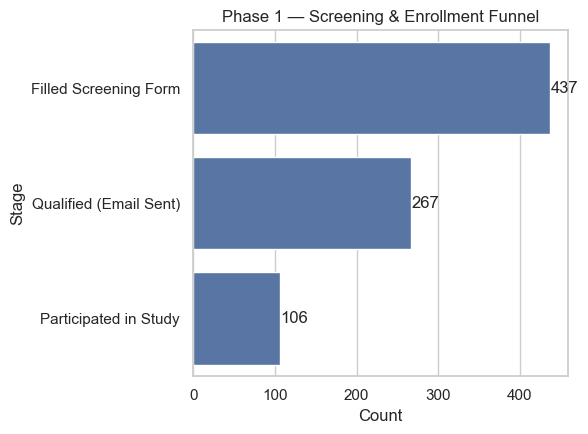

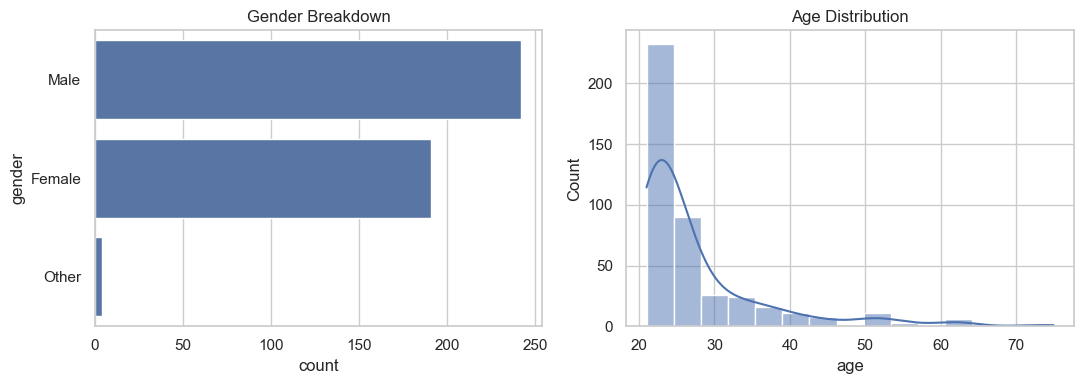

Conversion (Filled → Qualified): 61.1%
Conversion (Qualified → Participated): 39.7%


In [3]:
# ============================================
# Cell 3 — Funnel + basic demographics
# ============================================

n_filled = len(elig_screen)
n_qualified = elig_screen.get("qualified_email_sent", pd.Series(dtype=bool)).eq(True).sum()
n_completed = elig_screen.get("have_done_study", pd.Series(dtype=bool)).eq(True).sum()

print(f"Forms submitted: {n_filled}")
print(f"Qualified:       {n_qualified}")
print(f"Participated:    {n_completed}")

# Funnel bar chart
funnel = pd.DataFrame({
    "Stage": ["Filled Screening Form", "Qualified (Email Sent)", "Participated in Study"],
    "Count": [n_filled, n_qualified, n_completed]
})

plt.figure(figsize=(6, 4.5))
sns.barplot(data=funnel, y="Stage", x="Count")
plt.title("Phase 1 — Screening & Enrollment Funnel")
for i, v in enumerate(funnel["Count"]):
    plt.text(v + 0.5, i, str(v), va="center")
plt.tight_layout()
plt.show()

# Demographics: gender + age
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Gender distribution
if "gender" in elig_screen.columns:
    g = elig_screen["gender"].astype(str).str.strip()
    order = g.value_counts().index
    sns.countplot(y=g, order=order, ax=axs[0])
    axs[0].set_title("Gender Breakdown")
else:
    axs[0].axis("off")
    axs[0].set_title("Gender column not found")

# Age distribution
if "age" in elig_screen.columns:
    sns.histplot(elig_screen["age"], bins=15, kde=True, ax=axs[1])
    axs[1].set_title("Age Distribution")
else:
    axs[1].axis("off")
    axs[1].set_title("Age column not found")

plt.tight_layout()
plt.show()

# Conversion rates
conv1 = (n_qualified / n_filled * 100) if n_filled else np.nan
conv2 = (n_completed / max(n_qualified, 1) * 100) if n_qualified else np.nan
print(f"Conversion (Filled → Qualified): {conv1:.1f}%")
print(f"Conversion (Qualified → Participated): {conv2:.1f}%")


In [4]:
# ============================================
# Cell 4 — Derived eligibility rule from screening answers
# ============================================

def to_bool(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower().map({
        "yes": True, "y": True, "true": True, "1": True,
        "no": False, "n": False, "false": False, "0": False
    })

def col(name: str):
    if name in elig_screen.columns:
        return name
    low = {c.lower().strip(): c for c in elig_screen.columns}
    return low.get(name.lower().strip())

# Base criteria: must have license, willing, consumed last year
c_license  = to_bool(elig_screen[col("Do you have a valid driver’s license")]) \
    if col("Do you have a valid driver’s license") else pd.Series(False, index=elig_screen.index)

c_willing  = to_bool(elig_screen[col("Are you able and willing to drink alcohol?")]) \
    if col("Are you able and willing to drink alcohol?") else pd.Series(False, index=elig_screen.index)

c_lastyear = to_bool(elig_screen[col("Have you consumed alcohol within the last year?")]) \
    if col("Have you consumed alcohol within the last year?") else pd.Series(False, index=elig_screen.index)

base_ok = (c_license.fillna(False) & c_willing.fillna(False) & c_lastyear.fillna(False))

# Risk flags (any True → exclude)
risk_cols_names = [
    "Do you have a history of photosensitive seizures, loss of awareness or symptoms linked to an epileptic condition?",
    "Are you prone to motion sickness or uncomfortable with Virtual Reality or other simulated environments?",
    "Are you pregnant?",
    "Do you have a current or past addiction to drugs and/or alcohol?",
    "Do you have any vision related defects (not considering prescription glasses/lenses)?",
    "Are you deaf or hard of hearing and the condition cannot be corrected by hearing aids?",
    "Do you currently possess any contagious or infectious disease, including but not limited to skin conditions?",
    "Are you suffering from any ailments such as flu, cold, migraines, or headaches?",
    "Are you currently or do you often feel sick, tired, or sleepy?",
    "Do you use any electronic devices such as including pacemakers, electronic infusions pumps, stimulators, defibrillators or similar?",
    "Do you have any musculoskeletal disorders such as carpal tunnel syndrome, tendonitis, tenosynovitis, vibration syndromes, and other conditions?",
]

risk_bool_df = []
for nm in risk_cols_names:
    c = col(nm)
    if c:
        risk_bool_df.append(to_bool(elig_screen[c]).fillna(False).rename(c))

if risk_bool_df:
    risk_any = pd.concat(risk_bool_df, axis=1).any(axis=1)
else:
    risk_any = pd.Series(False, index=elig_screen.index)

elig_screen["eligibility_rule"] = (base_ok & ~risk_any)

# Agreement with admin’s qualified flag
if "qualified_email_sent" in elig_screen.columns:
    agree = (elig_screen["eligibility_rule"] == elig_screen["qualified_email_sent"])
    print("Derived vs admin-qualified agreement:", round(agree.mean() * 100, 1), "%")
    print("Counts — derived True/False:", elig_screen["eligibility_rule"].value_counts().to_dict())
else:
    print("Counts — derived True/False:", elig_screen["eligibility_rule"].value_counts().to_dict())


Derived vs admin-qualified agreement: 57.4 %
Counts — derived True/False: {True: 371, False: 66}


C:\Users\vishs\AppData\Local\Temp\ipykernel_2232\849427965.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  risk_bool_df.append(to_bool(elig_screen[c]).fillna(False).rename(c))


C:\Users\vishs\AppData\Local\Temp\ipykernel_2232\2508471867.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_col)["eligibility_rule"]


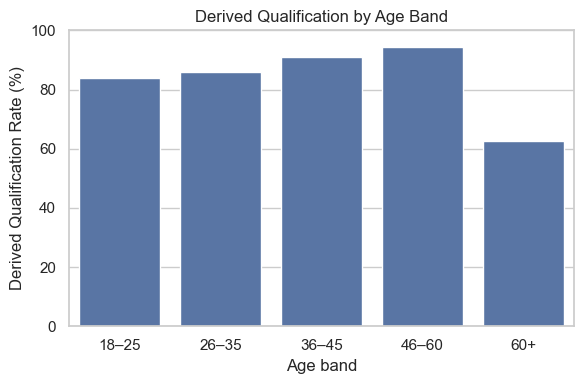

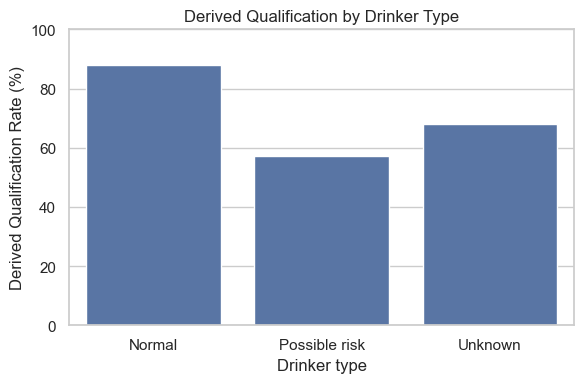

C:\Users\vishs\AppData\Local\Temp\ipykernel_2232\2508471867.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_col)["eligibility_rule"]


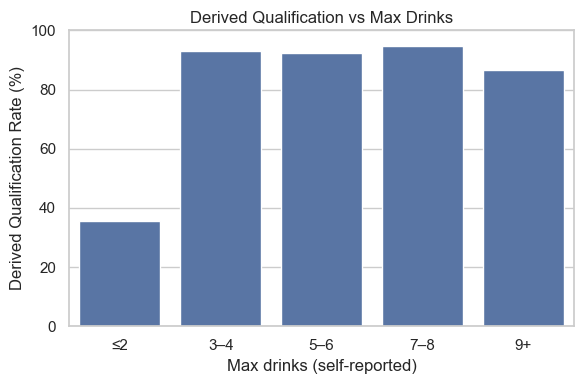

C:\Users\vishs\AppData\Local\Temp\ipykernel_2232\2508471867.py:70: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


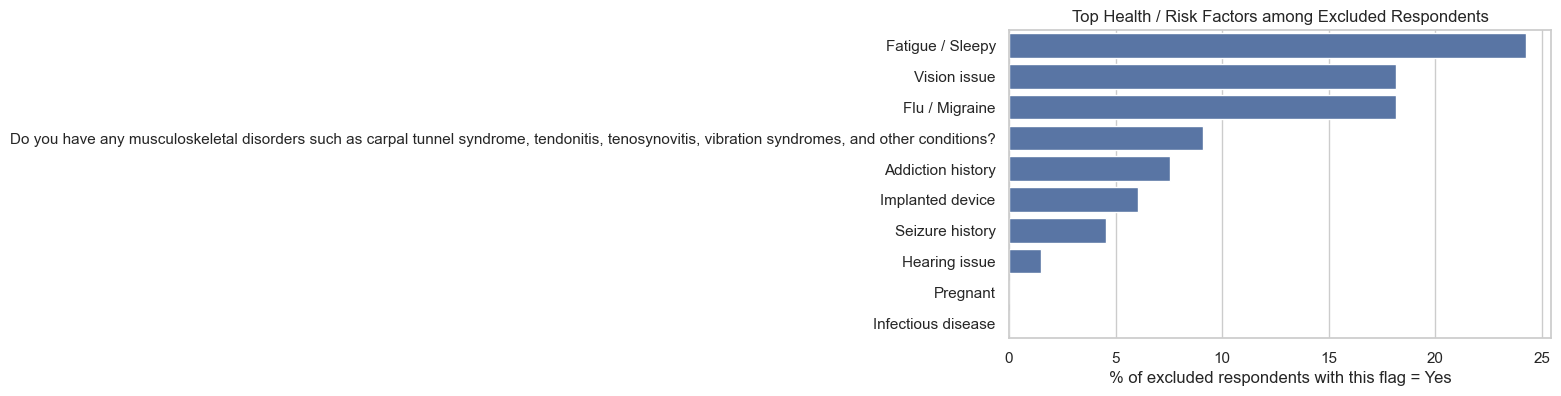

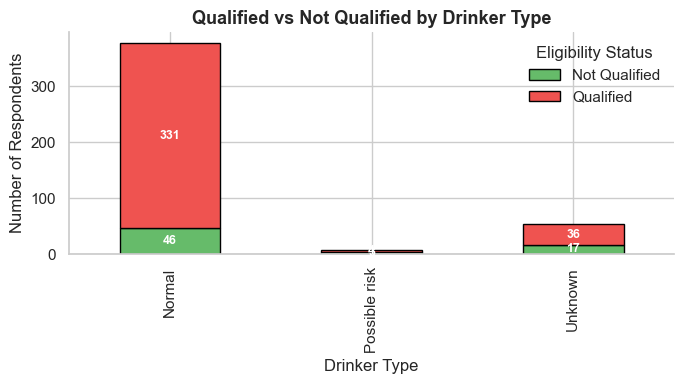

In [5]:
# ============================================
# Cell 5 — Qualification by subgroups
# ============================================

def rate_bar(group_col: str, title: str, xlabel: str):
    if group_col not in elig_screen.columns:
        return
    grp = (
        elig_screen
        .dropna(subset=[group_col])
        .groupby(group_col)["eligibility_rule"]
        .mean()
        .mul(100)
        .sort_index()
    )
    if grp.empty:
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x=grp.index.astype(str), y=grp.values)
    plt.ylabel("Derived Qualification Rate (%)")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# By age band
if "age_band" in elig_screen.columns:
    rate_bar("age_band", "Derived Qualification by Age Band", "Age band")

# By drinker type
if "drinker_type" in elig_screen.columns:
    rate_bar("drinker_type", "Derived Qualification by Drinker Type", "Drinker type")

# By max drinks band
if "max_drinks_one_sitting" in elig_screen.columns:
    bins   = [-np.inf, 2, 4, 6, 8, np.inf]
    labels = ["≤2", "3–4", "5–6", "7–8", "9+"]
    elig_screen["max_drink_band"] = pd.cut(
        elig_screen["max_drinks_one_sitting"], bins=bins, labels=labels
    )
    rate_bar("max_drink_band", "Derived Qualification vs Max Drinks", "Max drinks (self-reported)")

# Top exclusion contributors among those with eligibility_rule == False
if risk_bool_df:
    drivers = pd.concat(risk_bool_df, axis=1)[~elig_screen["eligibility_rule"]]
    if not drivers.empty:
        contrib = drivers.mean().mul(100).sort_values(ascending=False).head(10)

        # Shorter labels for plotting
        rename_short = {
            "Are you currently or do you often feel sick, tired, or sleepy?": "Fatigue / Sleepy",
            "Do you have any vision related defects (not considering prescription glasses/lenses)?": "Vision issue",
            "Are you suffering from any ailments such as flu, cold, migraines, or headaches?": "Flu / Migraine",
            "Do you have a current or past addiction to drugs and/or alcohol?": "Addiction history",
            "Do you use any electronic devices such as including pacemakers, electronic infusions pumps, stimulators, defibrillators or similar?": "Implanted device",
            "Do you have a history of photosensitive seizures, loss of awareness or symptoms linked to an epileptic condition?": "Seizure history",
            "Are you deaf or hard of hearing and the condition cannot be corrected by hearing aids?": "Hearing issue",
            "Are you pregnant?": "Pregnant",
            "Do you currently possess any contagious or infectious disease, including but not limited to skin conditions?": "Infectious disease",
        }

        contrib = contrib.rename(index=lambda x: rename_short.get(x, x))

        plt.figure(figsize=(7, 4))
        sns.barplot(x=contrib.values, y=contrib.index)
        plt.xlabel("% of excluded respondents with this flag = Yes")
        plt.ylabel("")
        plt.title("Top Health / Risk Factors among Excluded Respondents")
        plt.tight_layout()
        plt.show()

# Optional: stacked bar — Qualified vs Not Qualified by drinker type
if "eligibility_rule" in elig_screen.columns and "drinker_type" in elig_screen.columns:
    counts = (
        elig_screen
        .groupby(["drinker_type", "eligibility_rule"])
        .size()
        .unstack(fill_value=0)
        .rename(columns={True: "Qualified", False: "Not Qualified"})
    )

    order = ["Normal", "Possible risk", "Unknown"]
    counts = counts.reindex(order, axis=0).dropna(how="all")

    ax = counts.plot(
        kind="bar", stacked=True,
        color=["#66BB6A", "#EF5350"],
        figsize=(7, 4), edgecolor="black"
    )

    ax.set_title("Qualified vs Not Qualified by Drinker Type", fontsize=13, weight="bold")
    ax.set_xlabel("Drinker Type")
    ax.set_ylabel("Number of Respondents")
    ax.legend(title="Eligibility Status", loc="upper right", frameon=False)

    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="center", fontsize=9, color="white", weight="bold")

    sns.despine()
    plt.tight_layout()
    plt.show()


C:\Users\vishs\AppData\Local\Temp\ipykernel_2232\2259038502.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


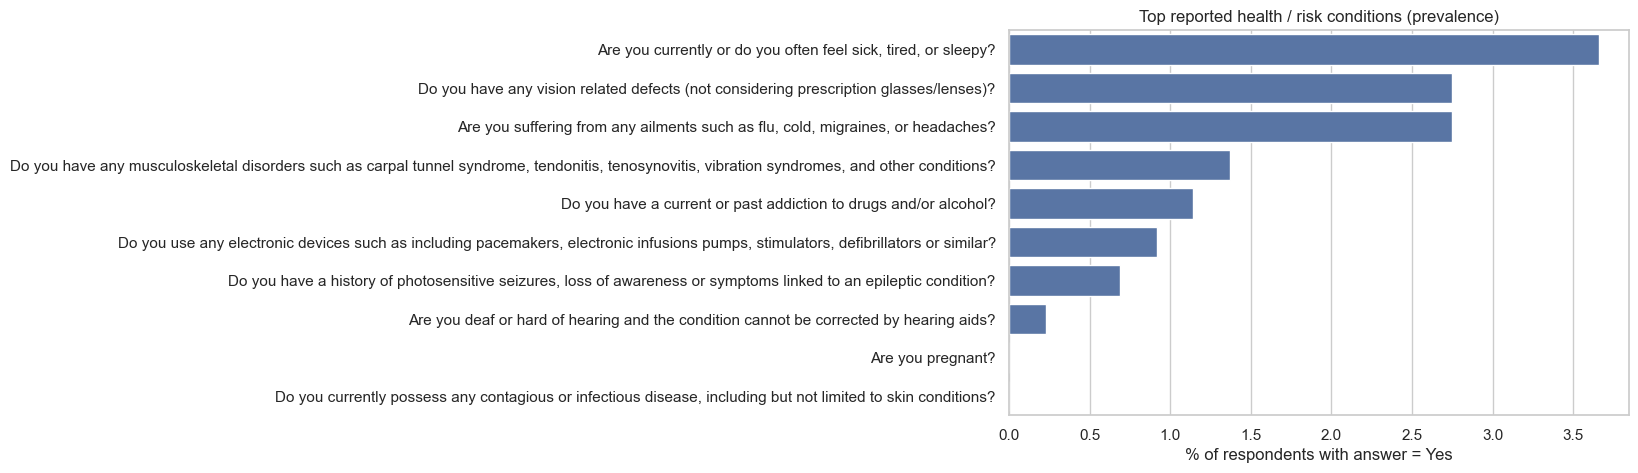

In [6]:
# ============================================
# Cell 6 — Risk prevalence (% Yes)
# ============================================

def coerce_yes_no(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower().map(
        {"yes": True, "y": True, "true": True, "1": True,
         "no": False, "n": False, "false": False, "0": False}
    )

risk_prev = {}
for nm in risk_cols_names:
    c = col(nm)
    if c and c in elig_screen.columns:
        b = coerce_yes_no(elig_screen[c])
        if b.notna().any():
            risk_prev[nm] = float(b.mean() * 100)

if risk_prev:
    prev_s = pd.Series(risk_prev).sort_values(ascending=False).head(12)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=prev_s.values, y=prev_s.index)
    plt.xlabel("% of respondents with answer = Yes")
    plt.ylabel("")
    plt.title("Top reported health / risk conditions (prevalence)")
    plt.tight_layout()
    plt.show()
else:
    print("No risk-like yes/no columns detected for prevalence.")
